# 전처리 가설 검증
- df_train + weather/oil 제외 추가데이터
- 모든 나라에 대해서 진행

# Setting

### Library

In [281]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

### Date

In [18]:
from datetime import date, timedelta


def set_week(df, date):
    '''
    df : datetime 형식의 컬럼을 가지고 있는 dataframe
    date : df에서 datetime 형식을 가진 컬럼명
    return : date의 연도 컬럼과 주차 컬럼을 추가한 dataframe
    '''
    df[date] = pd.to_datetime(df[date])
    df[date] = df[date].dt.date
    df['year'] = df.apply(func=lambda x: x[date].isocalendar()[0], axis=1)
    df['week'] = df.apply(func=lambda x: x[date].isocalendar()[1], axis=1)
    df.drop(date, axis=1, inplace=True)
    

def check_week(df):
    '''
    df에 date가 전부 있는지 확인
    '''
    cnt = 0
    sdate = date(2015, 12, 28)   # start date
    edate = date(2019, 12, 30)   # end date
    delta = edate - sdate       # as timedelta
    mem = set()
    
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        year, week = day.isocalendar()[0], day.isocalendar()[1]
        if year * 100 + week in mem:
            continue
        mem.add(year * 100 + week)
        if df[(df['year'] == year) & (df['week'] == week)].empty:
            print((year, week), end="")
            cnt += 1
    if cnt > 0:
        print()
    print("missing", cnt, "values")    

### Model

In [576]:
def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5


def train_model(train_data, target_data, model=LinearRegression()):  # baseline model : LInearRegression
    x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, random_state=0)

    model.fit(x_train, y_train)
    print("Model Training Complete!")

    pred_train, pred_test = model.predict(x_train), model.predict(x_test)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(pred_train, y_train, s=10)
    plt.xlabel("Predicted price")
    plt.ylabel("Actual price")
    plt.show()

    # cvs = cross_val_score(model, x_test, y_test, cv = 5)
    # print(">> cross_val_score mean =", cvs.mean())
    print(">> RMSE train =", RMSE(y_train, pred_train))
    print(">> RMSE validation =", RMSE(y_test, pred_test))
    print(">> MAE train =", mean_absolute_error(pred_train, y_train))
    print(">> MAE validation =", mean_absolute_error(pred_test, y_test))
    print("-------------------------------------------------")
    
    return model

    
def print_importance(model, df, added_columns):
    importance = model.coef_
    fs_data = []
    for i, x in enumerate(importance):
        fs_data.append([abs(x), df.columns[i]])
    fs_data.sort(key=lambda x: x[0], reverse=True)
   
    # 추가한 컬럼의 중요도
    for i in range(len(fs_data)):
        if fs_data[i][1] in added_columns:
            print(fs_data[i][1], ":", fs_data[i][0] ,">", i, "순위")
    print("-------------------------------------------------")
    print("총", len(fs_data) , "개")
    

### Data directory

In [4]:
root = os.path.join(os.getcwd(), 'DATA')

### Merging dataframes

In [416]:
from functools import reduce

def merge_df(df_list):
    return reduce(lambda  left,right: pd.merge(left,right, on=['year', 'week'], how='left'), df_list)

# Import Data

In [363]:
df_train = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_oil = pd.read_csv(os.path.join(root, 'preprocessed_oil.csv'))
df_weather_kr = pd.read_csv(os.path.join(root, 'preprocessed_weather_korea.csv'))
df_cpi = pd.read_csv(os.path.join(root, 'preprocessed_cpi.csv'))

# Baseline Dataframe
**df_train**:  
- 'REG_DATE' to 'year', 'week'
- One hot encoding on categorical features

## Preprocess

In [364]:
df0_base = df_train.copy()

### Add Columns

In [365]:
df0_base = df0_base.replace([np.datetime64('2017-01-01'), np.datetime64('2017-01-06')],
                            [np.datetime64('2017-01-02'), np.datetime64('2017-01-09')])

In [366]:
set_week(df0_base, 'REG_DATE')

In [367]:
check_week(df0_base)

missing 0 values


### One hot encoding

In [390]:
# P_IMPORT_TYPE
import_type_list = set()
for tmp in df0_base.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add('P_IMPORT_TYPE' + a)
for name in import_type_list:
    df0_base[name] = 0
    df0_base.loc[df0_base['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

AttributeError: 'DataFrame' object has no attribute 'P_IMPORT_TYPE'

In [369]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df0_base = pd.get_dummies(df0_base, columns=one_hot)

### Drop Columns

In [370]:
drop = ['P_TYPE', 'P_IMPORT_TYPE']
df0_base.drop(columns = drop, inplace=True)

## Feature Selection & Modeling

#### Numerical Features

In [371]:
numerical_columns = ['P_PRICE', 'year', 'week']

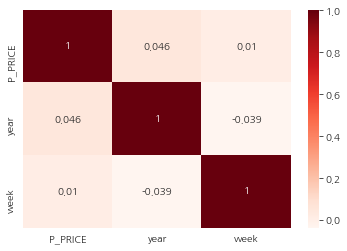

In [372]:
#Using Pearson Correlation
plt.figure(figsize=(6, 4))
cor = df0_base[numerical_columns].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

날짜 데이터('year', 'week')는 P_PRICE 결정에 큰 영향을 미치지 않음을 확인 할 수 있다  
다만, 데이터를 추가하는 기준으로 사용해야하므로 인덱스로 가져가준다

Model Training Complete!


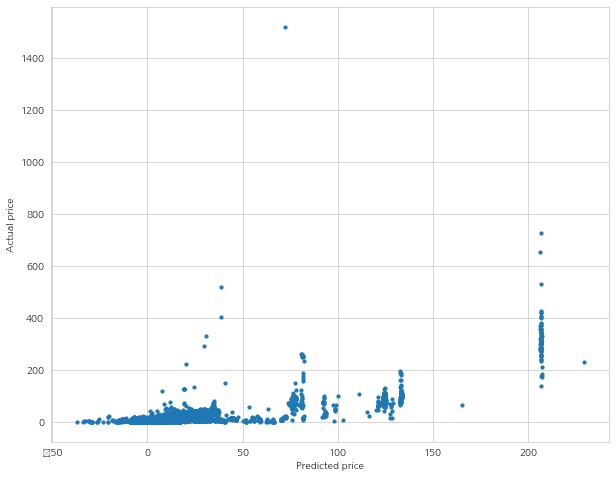

>> RMSE train = 14.252151791889126
>> RMSE validation = 1468529069.0295963
>> MAE train = 4.178646773013757
>> MAE validation = 48779936.58809473


In [373]:
model0 = train_model(df0_base.drop(columns=['P_PRICE']), df0_base['P_PRICE'])

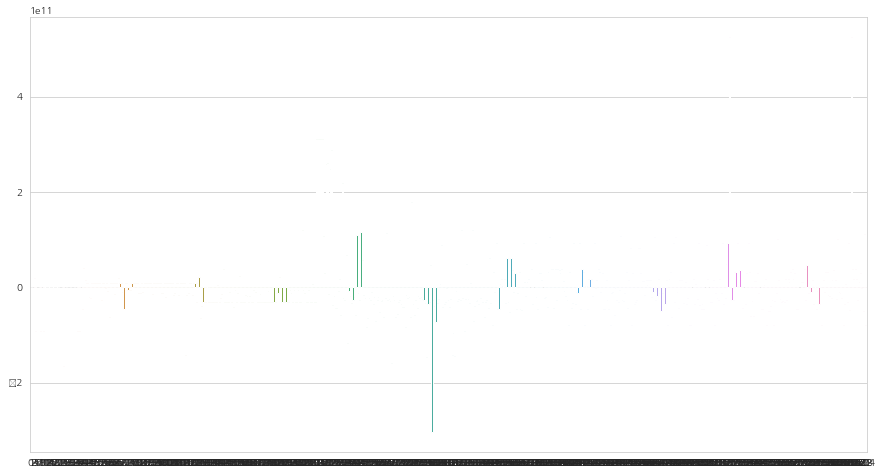

In [374]:
# plot feature importance
importance = model0.coef_
plt.figure(figsize=(15, 8))
sns.barplot([x for x in range(len(importance))], importance)
plt.show()

In [382]:
fs_data = []
deleted = []
for i, x in enumerate(importance):
    fs_data.append([abs(x), df0_base.columns[i]])
fs_data.sort(key=lambda x: x[0], reverse=True)

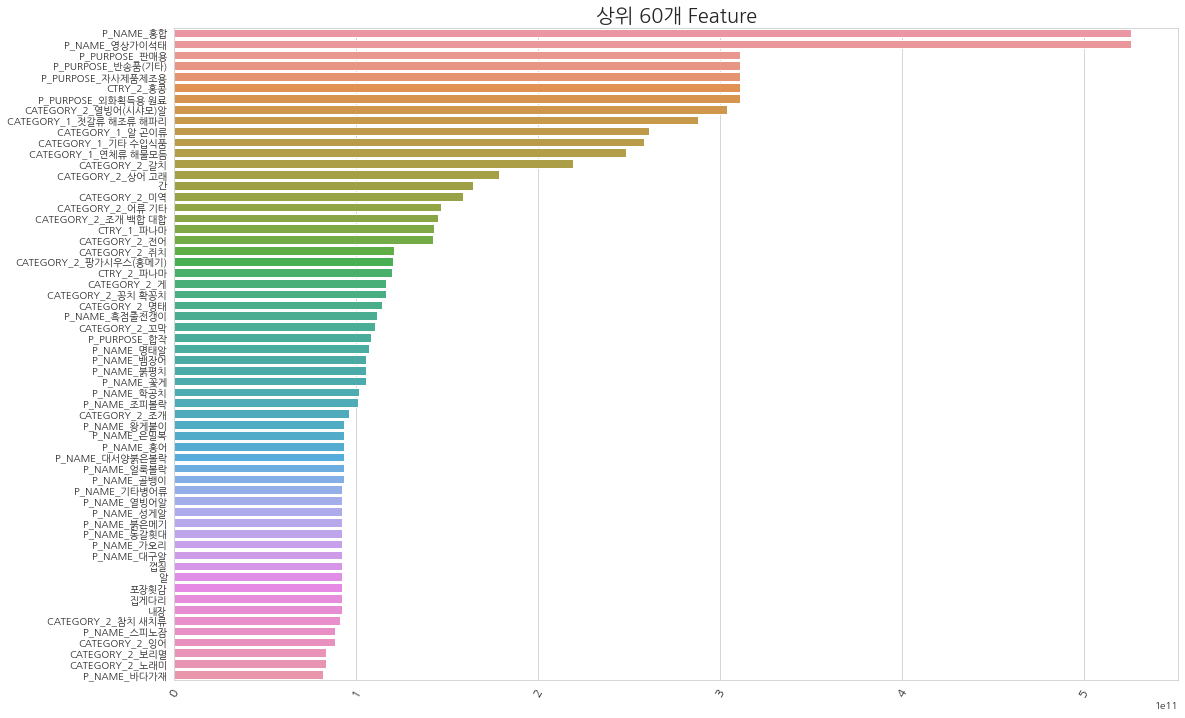

In [388]:
plt.figure(figsize=(18, 12))
sns.barplot(x=[i[0] for i in fs_data[:60]], y=[i[1] for i in fs_data[:60]])
plt.xticks(fontsize=12, rotation=60)
plt.title('상위 60개 Feature', fontsize=title_size)
plt.show()

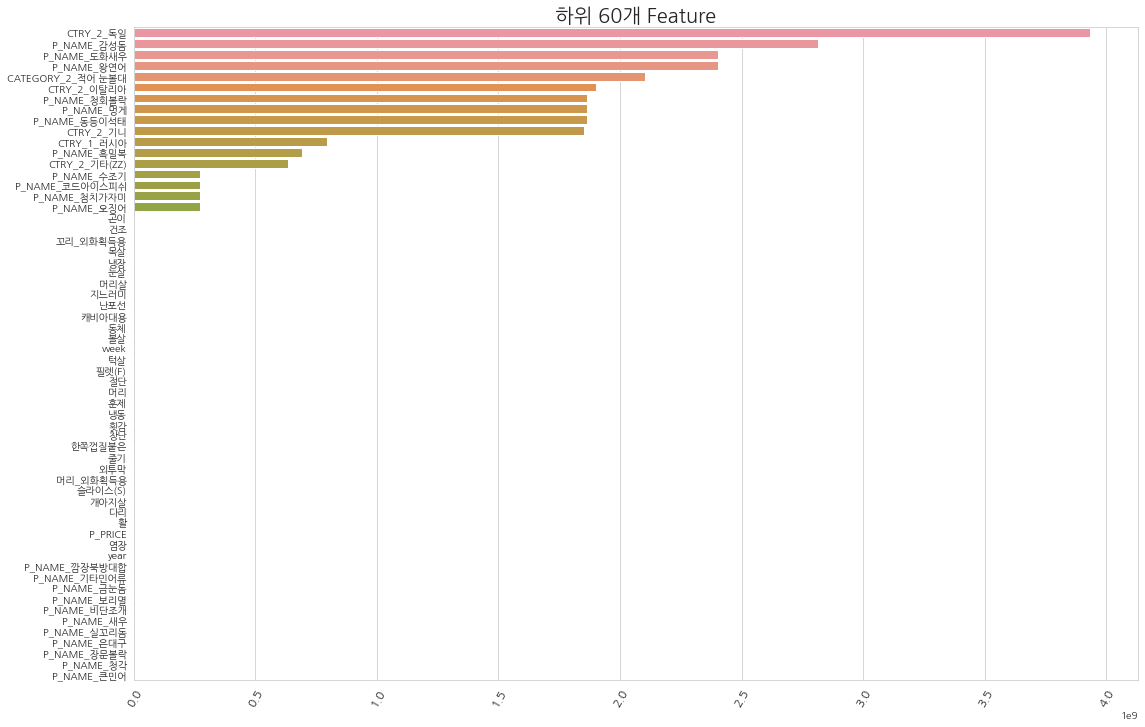

In [389]:
plt.figure(figsize=(18, 12))
sns.barplot(x=[i[0] for i in fs_data[-60:]], y=[i[1] for i in fs_data[-60:]])
plt.xticks(fontsize=12, rotation=60)
plt.title('하위 60개 Feature', fontsize=title_size)
plt.show()

In [297]:
# def plot_fs(x, y, length, num):
#     plt.figure(figsize=(10, 10))
#     plt.subplot(1, 2, 1 if num % 2 == 0 else 2)
#     if num == split - 1:
#         sns.barplot(x=y[length*num:], y=x[length*num:])
#     else:
#         sns.barplot(x=y[length*num:length*(num+1)], y=x[length*num:length*(num+1)])
#     if num % 2 == 1:
#         plt.show()
    

# # plot feature importance
# split = 10
# length = len(fs_data) // split
# for num in range(split):
#     plot_fs(x, y, length, num)

# Adding Columns
- 어종별 수 컬럼 추가
- 수입용도 수 컬럼 추가
- 가공여부 컬럼 추가

In [578]:
df1_add_columns = df_train.copy()

## Preprocess

In [580]:
df1_add_columns = df1_add_columns.replace([np.datetime64('2017-01-01'), np.datetime64('2017-01-06')],
                                          [np.datetime64('2017-01-02'), np.datetime64('2017-01-09')])

In [581]:
set_week(df1_add_columns, 'REG_DATE')  # 날짜 추가

#### Add columns

In [582]:
added_columns = []

In [583]:
def get_cnt(df, column, new_column):
    value_dict = {}
    for name, value in zip(df[column].value_counts().index, df[column].value_counts()):
        value_dict[name] = value
    def value(col):
        return value_dict[col]

    df[new_column] = df[column].apply(value)

In [584]:
# 제조국 수 컬럼 추가
get_cnt(df1_add_columns, 'CTRY_1', 'ctry1_cnt')
added_columns.append('ctry1_cnt')

In [585]:
# 수출국 수 컬럼 추가
get_cnt(df1_add_columns, 'CTRY_2', 'ctry2_cnt')
added_columns.append('ctry2_cnt')

In [586]:
# 수입용도 수 컬럼 추가
get_cnt(df1_add_columns, 'P_PURPOSE', 'purpose_cnt')
added_columns.append('purpose_cnt')

In [587]:
#  
get_cnt(df1_add_columns, 'CATEGORY_1', 'category_1')
added_columns.append('category_1')

In [588]:
#  
get_cnt(df1_add_columns, 'CATEGORY_2', 'category_2')
added_columns.append('category_2')

In [589]:
# 어종별 수 컬럼 추가
get_cnt(df1_add_columns, 'P_NAME', 'name_cnt')
added_columns.append('name_cnt')

In [590]:
# 가공 여부 컬럼 추가
df1_add_columns['is_processed'] = (df1_add_columns['CTRY_1'] != df1_add_columns['CTRY_2'])
added_columns.append('is_processed')

In [593]:
# 수입형태
import_type_list = set()
for tmp in df1_add_columns.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)
for name in import_type_list:
    df1_add_columns[name] = 0
    df1_add_columns.loc[df1_add_columns['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [595]:
# 수입형태 수 컬럼 추가
df1_add_columns['import_cnt'] = 0
for i, row in df1_add_columns.iterrows():
    for name in import_type_list:
        if row[name] == 1:
            df1_add_columns.at[i, 'import_cnt'] += 1
added_columns.append('import_cnt')

In [553]:
# 분기 추가


In [554]:
# 대륙끼리 묶기

In [555]:
# P_PRICE 이상한거 빼기

#### One hot encoding

In [604]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df1_add_columns = pd.get_dummies(df1_add_columns, columns=one_hot)

### Drop Columns

In [605]:
drop = ['P_TYPE', 'P_IMPORT_TYPE']
df1_add_columns.drop(columns = drop, inplace=True)

## Check

In [596]:
df1_add_columns['name_cnt'].describe()

count    42073.000000
mean       803.035129
std        739.916364
min          1.000000
25%        208.000000
50%        512.000000
75%       1298.000000
max       2601.000000
Name: name_cnt, dtype: float64

In [597]:
df1_add_columns['import_cnt'].value_counts()

1    28079
2     7194
3     4780
4     1518
5      502
Name: import_cnt, dtype: int64

In [598]:
df1_add_columns['is_processed'].value_counts()

False    37634
True      4439
Name: is_processed, dtype: int64

## Train

Model Training Complete!


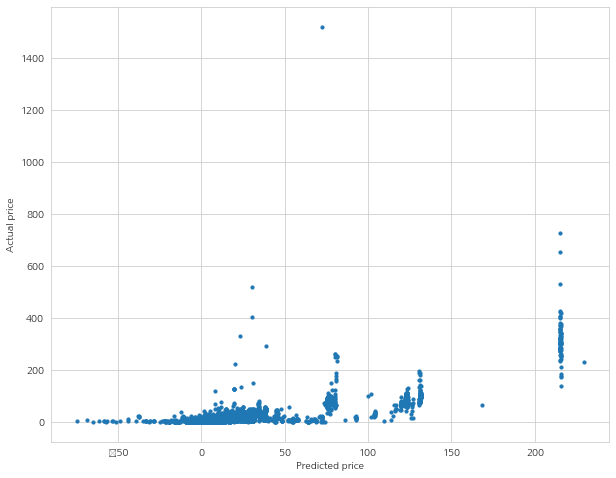

>> RMSE train = 14.09282714512467
>> RMSE validation = 10.295894978532743
>> MAE train = 4.0477088771623
>> MAE validation = 4.037554324067968
-------------------------------------------------


In [606]:
model1 = train_model(df1_add_columns.drop(columns=['P_PRICE']), df1_add_columns['P_PRICE'])

In [607]:
print_importance(model1, df1_add_columns, added_columns)

name_cnt : 28.946773964235412 > 52 순위
import_cnt : 9.891914973716874 > 133 순위
category_2 : 0.003639909884397996 > 616 순위
ctry1_cnt : 0.002545537644839155 > 618 순위
category_1 : 0.0016752522521724655 > 619 순위
purpose_cnt : 0.00024672662932799516 > 620 순위
ctry2_cnt : 6.113680833716266e-05 > 621 순위
is_processed : 3.1523757826334986e-08 > 622 순위
-------------------------------------------------
총 670 개


- name_cnt와 import_Cnt 는 중요도가 꽤나 높다
- 그 외는 작다
- 그럼에도 변수 추가를 통해 모델 정확도가 상승한 것을 확인할 수 있다

# Adding Data

#### Add Data

In [418]:
df2_add_data = merge_df([df1_add_columns, df_oil, df_weather_kr, df_cpi])

## Train

Model Training Complete!


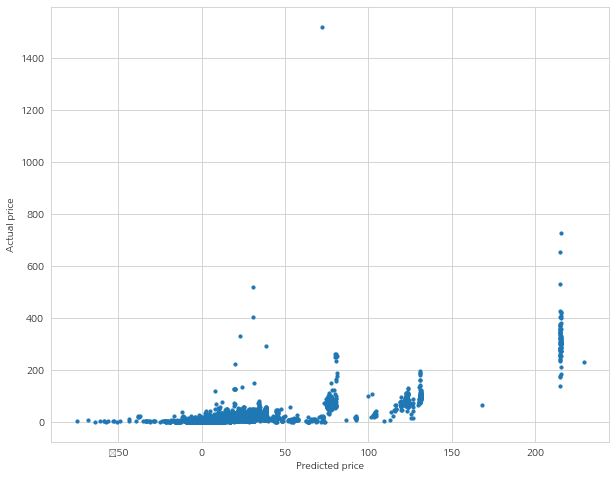

>> RMSE train = 14.089951556657166
>> RMSE validation = 2478942.8605961115
>> MAE train = 4.05627029096372
>> MAE validation = 47161.73859254781


In [424]:
model2 = train_model(df2_add_data.drop(columns=['P_PRICE']), df2_add_data['P_PRICE'])

In [431]:
# plot feature importance
importance = model2.coef_

In [426]:
fs_data = []
deleted = []
for i, x in enumerate(importance):
    fs_data.append([abs(x), df2_add_data.columns[i]])
fs_data.sort(key=lambda x: x[0], reverse=True)

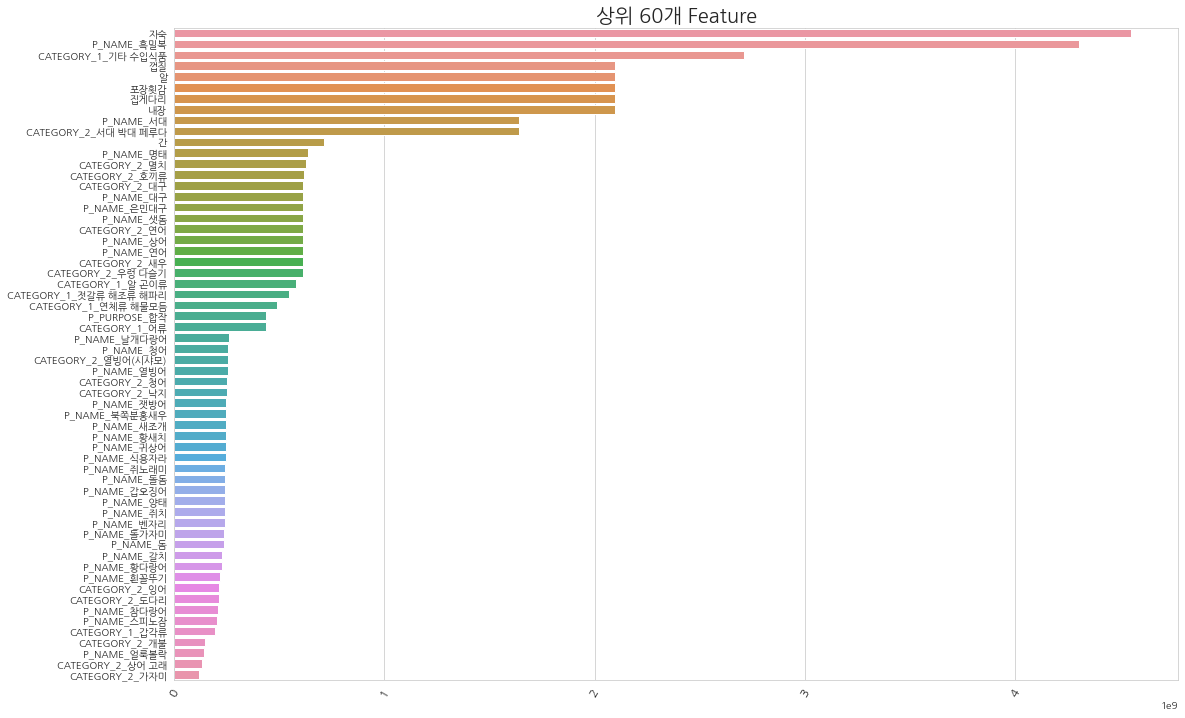

In [427]:
plt.figure(figsize=(18, 12))
sns.barplot(x=[i[0] for i in fs_data[:60]], y=[i[1] for i in fs_data[:60]])
plt.xticks(fontsize=12, rotation=60)
plt.title('상위 60개 Feature', fontsize=title_size)
plt.show()

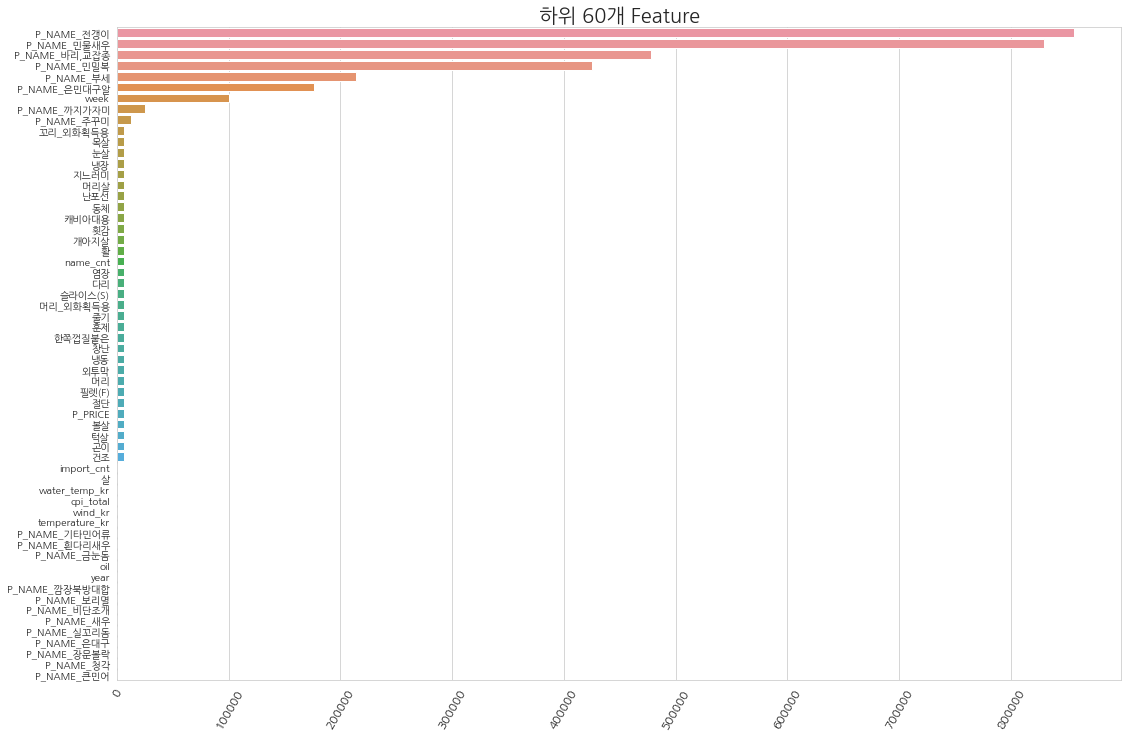

In [428]:
plt.figure(figsize=(18, 12))
sns.barplot(x=[i[0] for i in fs_data[-60:]], y=[i[1] for i in fs_data[-60:]])
plt.xticks(fontsize=12, rotation=60)
plt.title('하위 60개 Feature', fontsize=title_size)
plt.show()

In [429]:
# 추가한 컬럼의 중요도
for i in range(len(fs_data)):
    if fs_data[i][1] not in df1_add_columns.columns:
        print(fs_data[i][1], ":", fs_data[i][0] ,">", i, "순위")

water_temp_kr : 0.13209044933319092 > 616 순위
cpi_total : 0.10801076889038086 > 617 순위
wind_kr : 0.030284717679023743 > 618 순위
temperature_kr : 0.02190321683883667 > 619 순위
oil : 0.004505902528762817 > 623 순위


# Dropping columns

In [444]:
df3_drop_columns = df_train.copy()

### Drop Columns